In [1]:
from virusPropagationModel import ModeledPopulatedWorld,Simulation
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
 

In [2]:
modeledWorld1 = ModeledPopulatedWorld(500,200)

In [3]:
simulation1 = Simulation(modeledWorld1,200)


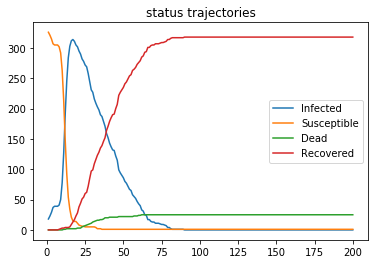

In [4]:
simulation1.plot_status_timecourse()


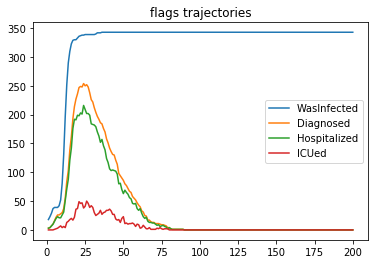

In [5]:
simulation1.plot_flags_timecourse()


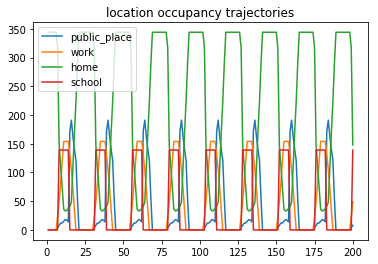

In [6]:
simulation1.plot_location_type_occupancy_timecourse()

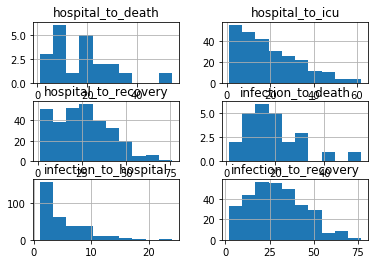

In [7]:
simulation1.plot_distributions_of_durations()

In [ ]:
simulation1.export_time_courses_as_csvs(identifier='testing') 
# Exports the CSVs to the outputs folder.
# Files marked with the identifier 'testing' get automatically deleted by the testrunner.
# Use a different identifier name if you want your outputs to remain in the folder.


In [ ]:
simulation2 = Simulation(simulation1,100) # Now Simulaition class objects can be used for subsequent simulation
simulation2.plot_status_timecourse()

